# MR Tree - local configuration

Srcipt for testing MR-Tree performance scalability on single node

In [1]:
from pyspark.sql import SparkSession

# Start a SparkSession
spark = SparkSession.builder.master("local[5]").appName("MySparkApp").getOrCreate()

## Data Processing

Data is sourced from https://archive.ics.uci.edu/dataset/2/adult

Steps:
- Load data into spark dataframe
- Preprocess data (fill na)
- Create embedings for categorical values
- Assemble into a single feature vector

### Load Data

In [2]:
# Read data into Spark DataFrame
df = spark.read.csv('data_a/adult.data', header=False, inferSchema=True)

# Fill NA
df = df.fillna(0)

df.show(5)

+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-------+------+----+----+--------------+------+
|_c0|              _c1|     _c2|       _c3| _c4|                _c5|               _c6|           _c7|   _c8|    _c9|  _c10|_c11|_c12|          _c13|  _c14|
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-------+------+----+----+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|2174.0| 0.0|40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|   0.0| 0.0|13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad| 9.0|           Divorced| Handlers-cleaners| Not-in-family| White|   Male|   0.0| 0.0|40.0| United-States| <=50K|
| 53|          Private|234721.0|      11th| 7.0| Married-c

In [3]:
# Define the features and label columns
feature_cols = df.columns[:-1]
label_col = df.columns[-1]

print("Feature columns: ", feature_cols)
print("Label column: ", label_col)

Feature columns:  ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13']
Label column:  _c14


### Get embeddings

In [4]:
# Dependencies
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

In [5]:
# String indexers for categorical columns
str_cols = [col for col in feature_cols if df.select(col).dtypes[0][1] == 'string']
feature_indexers = [StringIndexer(inputCol=col, outputCol=col+'_index') for col in str_cols]

# Get new feature column names
feature_cols_indexed = [indexer.getOutputCol() for indexer in feature_indexers] + [col for col in feature_cols if col not in str_cols]

In [6]:
# String indexer for label
labelIndexer = StringIndexer(inputCol=label_col, outputCol="indexedLabel")

In [7]:
# Transform dataframe
df_indexed = Pipeline(stages=feature_indexers+[labelIndexer]).fit(df).transform(df)

In [8]:
df_indexed.select("indexedLabel", *feature_cols_indexed).show(5, truncate=False)

+------------+---------+---------+---------+---------+---------+---------+---------+----------+---+--------+----+------+----+----+
|indexedLabel|_c1_index|_c3_index|_c5_index|_c6_index|_c7_index|_c8_index|_c9_index|_c13_index|_c0|_c2     |_c4 |_c10  |_c11|_c12|
+------------+---------+---------+---------+---------+---------+---------+---------+----------+---+--------+----+------+----+----+
|0.0         |4.0      |2.0      |1.0      |3.0      |1.0      |0.0      |0.0      |0.0       |39 |77516.0 |13.0|2174.0|0.0 |40.0|
|0.0         |1.0      |2.0      |0.0      |2.0      |0.0      |0.0      |0.0      |0.0       |50 |83311.0 |13.0|0.0   |0.0 |13.0|
|0.0         |0.0      |0.0      |2.0      |9.0      |1.0      |0.0      |0.0      |0.0       |38 |215646.0|9.0 |0.0   |0.0 |40.0|
|0.0         |0.0      |5.0      |0.0      |9.0      |0.0      |1.0      |0.0      |0.0       |53 |234721.0|7.0 |0.0   |0.0 |40.0|
|0.0         |0.0      |2.0      |0.0      |0.0      |4.0      |1.0      |1.0      

In [9]:
# Set all columns to integer type
for column_name in feature_cols_indexed + ["indexedLabel"]:
    df_indexed = df_indexed.withColumn(column_name, col(column_name).cast(IntegerType()))

In [10]:
df_indexed.select("indexedLabel", *feature_cols_indexed).show(5, truncate=False)

+------------+---------+---------+---------+---------+---------+---------+---------+----------+---+------+---+----+----+----+
|indexedLabel|_c1_index|_c3_index|_c5_index|_c6_index|_c7_index|_c8_index|_c9_index|_c13_index|_c0|_c2   |_c4|_c10|_c11|_c12|
+------------+---------+---------+---------+---------+---------+---------+---------+----------+---+------+---+----+----+----+
|0           |4        |2        |1        |3        |1        |0        |0        |0         |39 |77516 |13 |2174|0   |40  |
|0           |1        |2        |0        |2        |0        |0        |0        |0         |50 |83311 |13 |0   |0   |13  |
|0           |0        |0        |2        |9        |1        |0        |0        |0         |38 |215646|9  |0   |0   |40  |
|0           |0        |5        |0        |9        |0        |1        |0        |0         |53 |234721|7  |0   |0   |40  |
|0           |0        |2        |0        |0        |4        |1        |1        |9         |28 |338409|13 |0   |0  

### Assemble

In [11]:
assembler = VectorAssembler(inputCols=feature_cols_indexed, outputCol="features")

In [12]:
df_assembled = assembler.transform(df_indexed).select("features", "indexedLabel")

In [13]:
df_assembled.show(5, truncate=False)

+-------------------------------------------------------------------+------------+
|features                                                           |indexedLabel|
+-------------------------------------------------------------------+------------+
|[4.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,39.0,77516.0,13.0,2174.0,0.0,40.0]|0           |
|(14,[0,1,3,8,9,10,13],[1.0,2.0,2.0,50.0,83311.0,13.0,13.0])        |0           |
|(14,[2,3,4,8,9,10,13],[2.0,9.0,1.0,38.0,215646.0,9.0,40.0])        |0           |
|(14,[1,3,5,8,9,10,13],[5.0,9.0,1.0,53.0,234721.0,7.0,40.0])        |0           |
|[0.0,2.0,0.0,0.0,4.0,1.0,1.0,9.0,28.0,338409.0,13.0,0.0,0.0,40.0]  |0           |
+-------------------------------------------------------------------+------------+
only showing top 5 rows



## MR Tree training

Check time to train MR Tree on different dataset sizes

In [14]:
from pyspark.ml.classification import DecisionTreeClassifier
import time

# Init dataframe
df_train = df_assembled.alias('df_train')

# Init variables
performances = []
max_m = 200
step = 10

for i in range(0, max_m, step):
    # Create the DecisionTree model
    tree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='features')

    # Fit the model to the data and calculate performance
    dt = time.time()
    model = tree.fit(df_train)
    dt = time.time() - dt

    # Add performance to list
    performances.append((i + 1, dt))
    print(performances[-1])

    # Add data to train for next loop
    for _ in range(step):
        df_train = df_train.union(df_assembled)


(1, 3.2785346508026123)
(11, 9.272539854049683)
(21, 13.735514640808105)
(31, 21.25326681137085)
(41, 27.449604034423828)
(51, 39.29777765274048)
(61, 55.23787021636963)
(71, 71.9474790096283)
(81, 98.08044481277466)
(91, 126.01979684829712)
(101, 145.8112268447876)
(111, 167.3089108467102)
(121, 188.61424779891968)
(131, 247.2581136226654)
(141, 274.4721212387085)
(151, 312.91869163513184)
(161, 344.4505879878998)
(171, 371.48320603370667)
(181, 403.23466062545776)


In [ ]:
print(performances)

[(1, 3.223327398300171), (2, 3.2775678634643555), (3, 3.9192628860473633), (4, 5.012573719024658), (5, 5.73889684677124), (6, 6.441845655441284), (7, 7.488919973373413), (8, 8.452518939971924), (9, 9.527377605438232), (10, 10.488343715667725)]


In [ ]:
# Save to csv
with open('out/ml_tree_local.csv', 'w') as f:
    # Write header
    f.write('m,dt\n')

    # Write data
    for m, dt in performances:
        f.write(f'{m},{dt}\n')

## Visualise

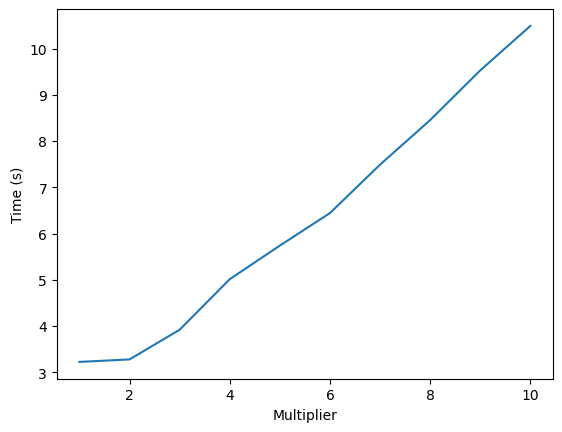

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segment_size = 32561*14*32

data_out = np.array([[m * segment_size , m, dt, dt/performances[0][1]] for m, dt in performances])

# Plot the performance
plt.plot(*zip(*performances))
plt.xlabel('Multiplier')
plt.ylabel('Time (s)')
plt.show()

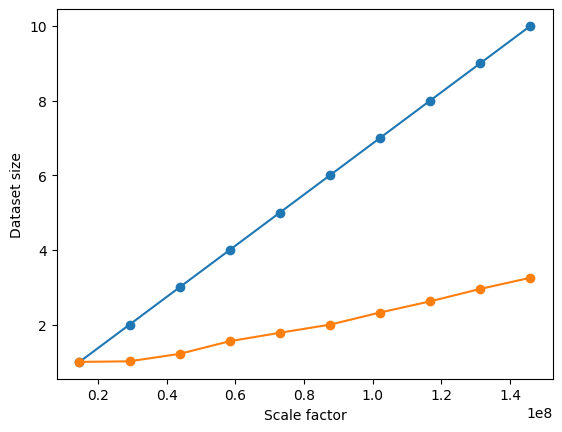

In [ ]:
import matplotlib.pyplot as plt

# Plot the performance
plt.plot(data_out[:, 0], data_out[:, 1], '-o')
plt.plot(data_out[:, 0], data_out[:, 3], '-o')
plt.xlabel('Dataset Size')
plt.ylabel('Scale factor')
plt.show()